<a href="https://colab.research.google.com/github/Snoraa/SU1/blob/main/103_Machine_learning_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo 03](https://staff.utia.cas.cz/novozada/ml1/103.png)

**Course website:** [http://zoi.utia.cas.cz/SU1](http://zoi.utia.cas.cz/SU1)


# Part 1: Object detection


<img src="https://staff.utia.cas.cz/novozada/ml1/perceptron0.png">
<img src="https://staff.utia.cas.cz/novozada/ml1/perceptron1.png">


**Input function - Linear model**
$$
\begin{aligned}
f(w,b) = w^tx + b
\end{aligned}
$$
where $b = w_0$ (in Fig.)
<br />

**Activation function - Unit step funciton**
$$
\begin{align}
        g(x) = \left\{
        \begin{array}{cl}
        1 & \text{if } x \ge 0 \\
        0 & \text{otherwise}
        \end{array}
        \right.
    \end{align}
$$

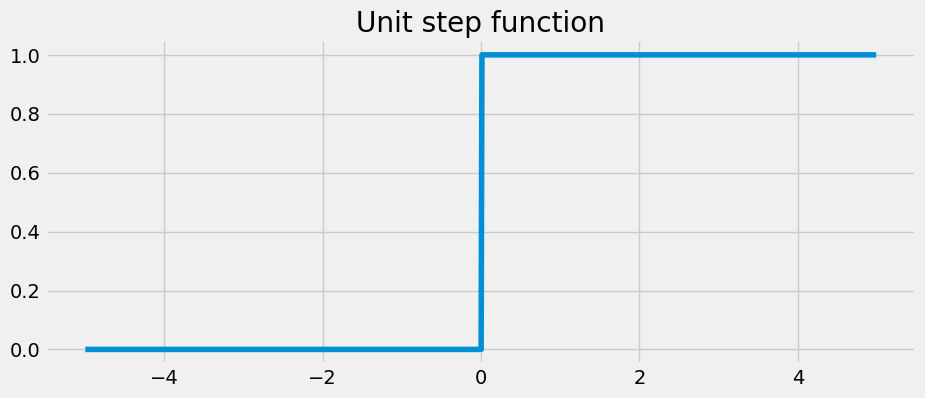

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.style.use('fivethirtyeight')

x = np.arange(-5,5,0.01)
y = np.where(x >= 0, 1, 0)

fig, ax = plt.subplots(figsize=(10,4))
plt.style.use('fivethirtyeight')

ax.plot(x,y)
ax.set_title('Unit step function')
plt.show()

**Approximation**
$$
\begin{aligned}
\hat{y} = g(f(w,b))=g(w^tx + b)
\end{aligned}
$$
<br />
**Perceptron update rule**
for each training sample $x_i$:
$$ \begin{aligned} w := w + \Delta w\end{aligned} $$
<br />
$$
\begin{aligned}
\Delta w := \alpha \cdot (y_i - \hat{y_i}) \cdot x_i
\end{aligned}
$$
where $ \alpha $ is a learning rate in $[0, 1]$
<br /><br />
**Update rule explanation**
$$\begin{matrix}
y & \hat{y} & y-\hat{y} \\
1 & 1 & 0 \\
1 & 0 & 1 \\
0 & 1 & -1 \\
0 & 0 & 0 \\
\end{matrix}$$
<br />
$ \Longrightarrow $ weights are pushed towards positive or negative target classs in case of missclassification


In [ ]:
import numpy as np

class Perceptron:
  def __init__(self, learning_rate=0.01, n_iters=1000):
    self.lr = learning_rate
    self.n_iters = n_iters
    self.activation_func = self._unit_step_func
    self.weights = None
    self.bias = None

  def fit(self, X, y):
    n_samples, n_features = X.shape

    # init parameters
    self.weights = np.zeros(n_features)
    self.bias = 0

    y_ = np.array([1 if i > 0 else 0 for i in y])

    for _ in range(self.n_iters):
      for idx, x_i in enumerate(X):
        linear_output = np.dot(x_i, self.weights) + self.bias
        y_predicted = self.activation_func(linear_output)

        # Perceptron update rule
        update = self.lr * (y_[idx] - y_predicted)

        self.weights += update * x_i
        self.bias += update

  def predict(self, X):
    linear_output = np.dot(X, self.weights) + self.bias
    y_predicted = self.activation_func(linear_output)
    return y_predicted

  def _unit_step_func(self, x):
    return np.where(x >= 0, 1, 0)

Perceptron classification accuracy 1.0


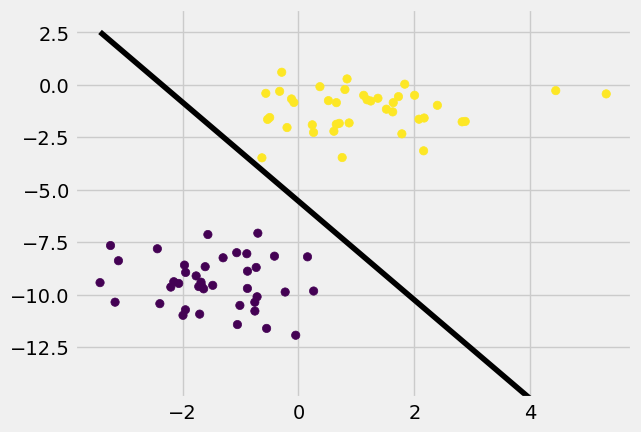

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets

def accuracy(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred) / len(y_true)
  return accuracy

X, y = datasets.make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=1.05, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

p = Perceptron(learning_rate=0.01, n_iters=100)
p.fit(X_train, y_train)
predictions = p.predict(X_test)

print("Perceptron classification accuracy", accuracy(y_test, predictions))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train)

x0_1 = np.amin(X_train[:, 0])
x0_2 = np.amax(X_train[:, 0])

x1_1 = (-p.weights[0] * x0_1 - p.bias) / p.weights[1]
x1_2 = (-p.weights[0] * x0_2 - p.bias) / p.weights[1]

ax.plot([x0_1, x0_2], [x1_1, x1_2], "k")

ymin = np.amin(X_train[:, 1])
ymax = np.amax(X_train[:, 1])
ax.set_ylim([ymin - 3, ymax + 3])

plt.show()

# Part 2: Decision Tree

## Theory

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

### Non-parametric
The term might sound a bit confusing: **non-parametric does not mean that they have NO parameters!** On the contrary, non-parametric models (can) become **more and more complex with an increasing amount of data**.

*   parametric model ➡ a finite number of parameters
   *   a fixed number of parameters
*   nonparametric models ➡ the number of parameters is (potentially) infinite.
   *   the complexity of the model grows with the number of training data


### Advantages of Decision Trees:
*   Simple to understand - trees can be visualised.
*   Fast data preparation without normalization.
*   The cost is logarithmic.
*   Able to handle both numerical and categorical data.
*   The condition is easily explained by boolean logic.

### Disadvantages of Decision Trees:
*   Easy to overfit with the wrong generalization. It is necessary to set up the minimum number of samples at a leaf node or the maximum depth of the tree.
*   Can be unstable due to small variations in the data.
*   Predictions are neither smooth nor continuous, but piecewise constant approximations.
*   The optimal decision tree is NP-complete problem - its learning algorithms are based on heuristic approaches (e.g. greedy algorithm) - such algorithms cannot guarantee to return the globally optimal decision tree.

### Example
<img src="https://staff.utia.cas.cz/novozada/ml1/dt.png">

### **Entropy**
$$
\begin{aligned}
E = -\sum p(X) \cdot \text{log}_2(p(X))
\end{aligned}
$$
<br />
where $p(X) = \frac{\#_x}{n}$

**Our example**
$$
\begin{aligned}
S = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
\end{aligned}
$$
<br />
$$
\begin{aligned}
E(S) = - \frac{5}{10} \cdot \text{log}_2 \frac{5}{10} - \frac{5}{10} \cdot \text{log}_2 \frac{5}{10} = - 0.5 \cdot \text{log}_2 0.5 - 0.5 \cdot \text{log}_2 0.5 = - 0.5 \cdot (-1) - 0.5 \cdot (-1) = 1
\end{aligned}
$$

### **Information Gain**
$$
\begin{aligned}
IG = E(\text{parent}) - [\text{weighted average}] \cdot E(\text{children})
\end{aligned}
$$

**Our example**
$$
\begin{aligned}
S &= [0, 0, 0, 0, 0, 1, 1, 1, 1, 1] \\
S_1 &= [0, 0, 1, 1, 1, 1, 1] \\
S_2 &= [0, 0, 0]
\end{aligned}
$$
<br />
$$
\begin{aligned}
IG &= E(\text{S}) - [w_1 * E(S_1) + w_2*E(S_2)]  \\
w_1 &= 7/10 \\
w_1 &= 3/10 \\
E(S_1) &= -\frac{2}{7} \cdot \text{log}_2 \frac{2}{7} - \frac{5}{7} \cdot \text{log}_2 \frac{5}{7} \dot{=} 0.863 \\
E(S_2) &= -\frac{3}{3} \cdot \text{log}_2 \frac{3}{3} = 0
\end{aligned}
$$
<br />
$$
\begin{aligned}
IG = 1 - [7/10 * 0.863 + 3/10*0] = 0.395 \\
\end{aligned}
$$

## Algorithm

### **Fit Decision Tree >> Build the tree**


1.   Start at the top node and at each node select the best split based on the best information gain.
2.   Greedy search: Loop over all features and over all thresholds (all possible feature values).
3.   Save the best split feature and split threshold at each node.
4.   Build the tree recursively.
5.   Apply some stopping criteria to stop growing, e.g.:
     *   maximum depth, minimum samples at the node, no more class distribution in node
6.   When we have a leaf node, store the most common class label of this node.


### **Predict the Results >> Go through the tree**


1.   Go through the tree recursively
2.   At each node look at the best split features of the test feature vector $x$ and go left or right - depending on $x[feautre_{idx}] \le \text{threshold}$
3.   When we reach the leaf node we return the stored most common class label.



## Code

### Classification data

In [ ]:
from collections import Counter

import numpy as np


def entropy(y):
  hist = np.bincount(y)
  ps = hist / len(y)
  return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:
  def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value

  def is_leaf_node(self):
    return self.value is not None


class DecisionTree:
  def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.n_feats = n_feats
    self.root = None

  def fit(self, X, y):
    self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
    self.root = self._grow_tree(X, y)

  def predict(self, X):
    return np.array([self._traverse_tree(x, self.root) for x in X])

  def _grow_tree(self, X, y, depth=0):
    n_samples, n_features = X.shape
    n_labels = len(np.unique(y))

    # stopping criteria
    if (
        depth >= self.max_depth
        or n_labels == 1
        or n_samples < self.min_samples_split
    ):
        leaf_value = self._most_common_label(y)
        return Node(value=leaf_value)

    feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

    # greedily select the best split according to information gain
    best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

    # grow the children that result from the split
    left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
    left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
    right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
    return Node(best_feat, best_thresh, left, right)

  def _best_criteria(self, X, y, feat_idxs):
    best_gain = -1
    split_idx, split_thresh = None, None
    for feat_idx in feat_idxs:
        X_column = X[:, feat_idx]
        thresholds = np.unique(X_column)
        for threshold in thresholds:
            gain = self._information_gain(y, X_column, threshold)

            if gain > best_gain:
                best_gain = gain
                split_idx = feat_idx
                split_thresh = threshold

    return split_idx, split_thresh

  def _information_gain(self, y, X_column, split_thresh):
    # parent loss
    parent_entropy = entropy(y)

    # generate split
    left_idxs, right_idxs = self._split(X_column, split_thresh)

    if len(left_idxs) == 0 or len(right_idxs) == 0:
        return 0

    # compute the weighted avg. of the loss for the children
    n = len(y)
    n_l, n_r = len(left_idxs), len(right_idxs)
    e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
    child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

    # information gain is difference in loss before vs. after split
    ig = parent_entropy - child_entropy
    return ig

  def _split(self, X_column, split_thresh):
    left_idxs = np.argwhere(X_column <= split_thresh).flatten()
    right_idxs = np.argwhere(X_column > split_thresh).flatten()
    return left_idxs, right_idxs

  def _traverse_tree(self, x, node):
    if node.is_leaf_node():
        return node.value

    if x[node.feature] <= node.threshold:
        return self._traverse_tree(x, node.left)
    return self._traverse_tree(x, node.right)

  def _most_common_label(self, y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

#### **Testing on Iris & Breast Data Sets**
*  [webside of the Iris](https://archive.ics.uci.edu/ml/datasets/iris)
*  [webside of the Breast](https://archive.ics.uci.edu/ml/datasets/iris)

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

def accuracy(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred) / len(y_true)
  return accuracy

# data = datasets.load_iris()
data = datasets.load_breast_cancer()
X, y = data.data, data.target

# print(data.DESCR)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy:", acc)

Accuracy: 0.9210526315789473


**For visualization, we use the $\text{sklearn.tree}$ package.**

'iris.pdf'

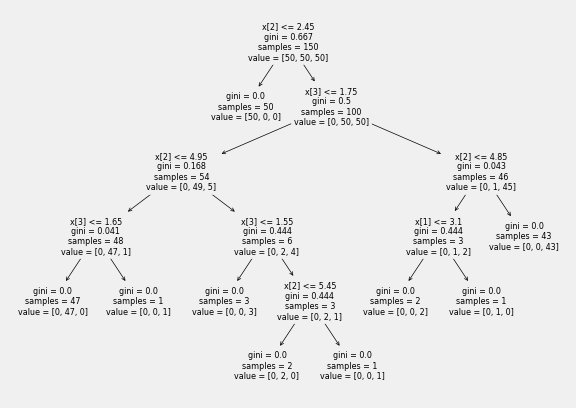

In [ ]:
from sklearn import datasets
from sklearn import tree
import graphviz
data = datasets.load_iris()
# data = datasets.load_breast_cancer()
X, y = data.data, data.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
tree.plot_tree(clf)
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=data.feature_names,
                                class_names=data.target_names,
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("iris")
# graph


'breast.pdf'

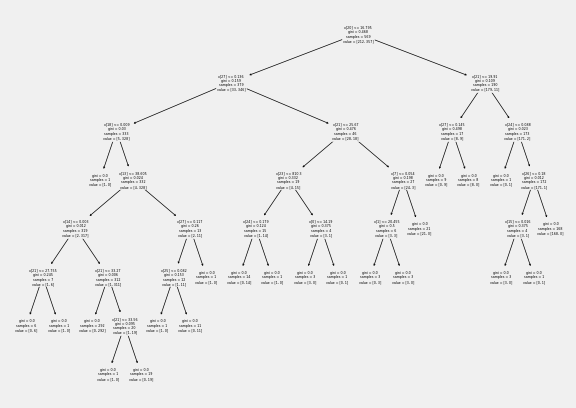

In [ ]:
from sklearn import datasets
from sklearn import tree
import graphviz

data = datasets.load_breast_cancer()
X, y = data.data, data.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
tree.plot_tree(clf)
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=data.feature_names,
                                class_names=data.target_names,
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("breast")
# graph

**The colors correspond to the individual species of iris.**

<ipython-input-8-5cb640f97546>:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
<ipython-input-8-5cb640f97546>:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
<ipython-input-8-5cb640f97546>:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
<ipython-input-8-5cb640f97546>:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
<ipython-input-8-5cb640f97546>:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
<ipython-input-8-5cb640f97546>:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
<ipython-input-8-5cb640f97546>:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
<ipython-input-8-5cb

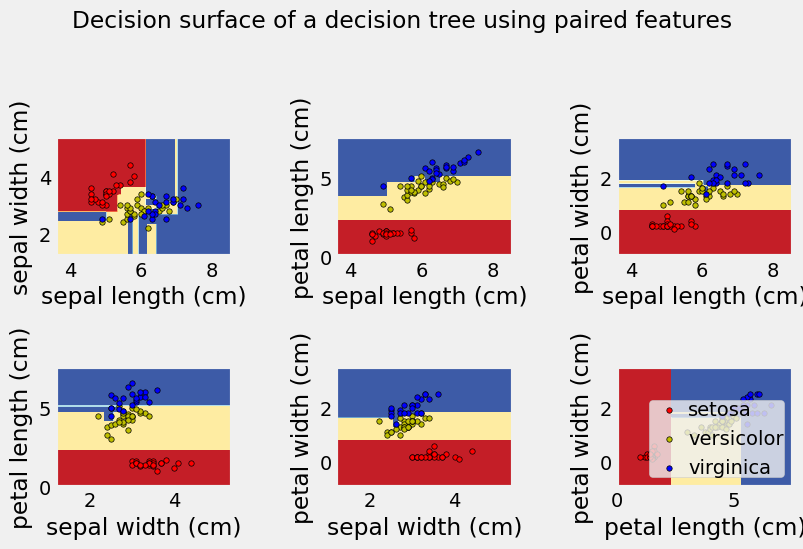

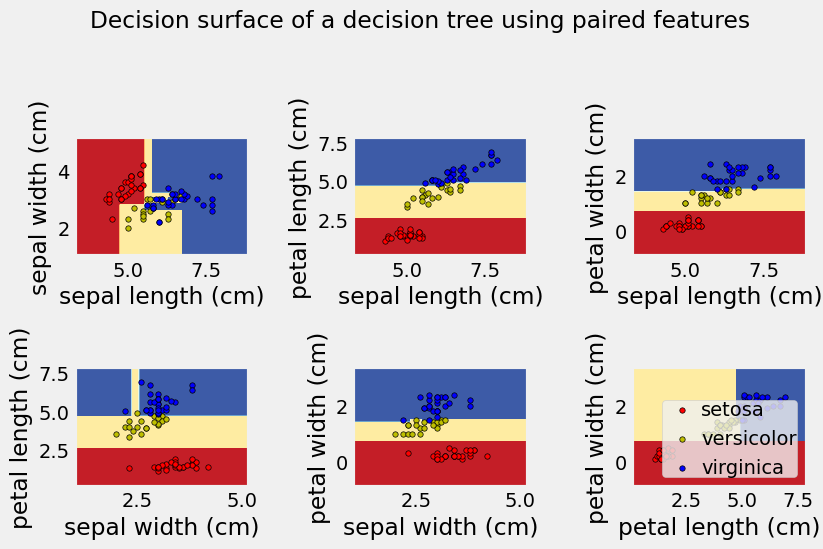

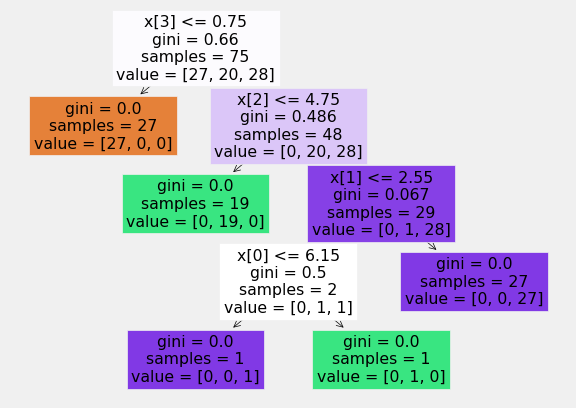

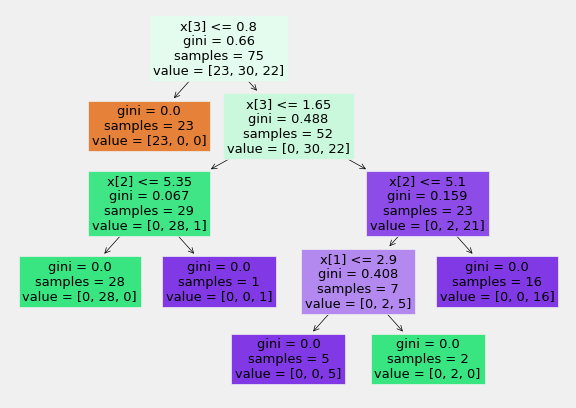

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

def show_decision_surface(X, y, data):
  figure(figsize=(9, 6))
  for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X_ = X[:, pair]
    y_ = y

    # Train
    clf = DecisionTreeClassifier().fit(X_, y_)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X_[:, 0].min() - 1, X_[:, 0].max() + 1
    y_min, y_max = X_[:, 1].min() - 1, X_[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(data.feature_names[pair[0]])
    plt.ylabel(data.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
      idx = np.where(y == i)
      plt.scatter(
        X_[idx, 0],
        X_[idx, 1],
        c=color,
        label=data.target_names[i],
        cmap=plt.cm.RdYlBu,
        edgecolor="black",
        s=15,
      )
  plt.suptitle("Decision surface of a decision tree using paired features")
  plt.tight_layout(pad=3.0)
  plt.legend(loc="lower right", borderpad=0, handletextpad=0)
  plt.axis("tight")

def show_decision_tree(X, y):
  # figure(figsize=(14,10))
  plt.figure()
  clf = DecisionTreeClassifier().fit(X,y)
  plot_tree(clf, filled=True)
  plt.show()

# Load data
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.5, random_state=123)
show_decision_surface(X_train, y_train, data)
show_decision_surface(X_test, y_test, data)
show_decision_tree(X_test, y_test)
show_decision_tree(X_train, y_train)

### Regression

  **Real example:** Imagine you have a bike sharing company in mountains. Our customers can rent a bike from a one location and return it at a different location using the lockers at the parking spots. Your demand is to predicting how many bikes are going to be used in the future.Based on predictions you will plan infrastructure improvements. Unfortunately, you don't know much about bike renting. All you have is a csv file where you have the number of bikes hired every day and how was the weather - temperature, humidity, and windspeed.

<img src="https://staff.utia.cas.cz/novozada/ml1/rentabike.png">

**Here are the data:**

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
import numpy as np

bikes = pd.read_csv('https://staff.utia.cas.cz/novozada/ml1/bikes.csv')
bikes.head()

,date,temperature,humidity,windspeed,count
0,2011-01-03,2.716070,45.715346,21.414957,120.0
1,2011-01-04,2.896673,54.267219,15.136882,108.0
2,2011-01-05,4.235654,45.697702,17.034578,82.0
3,2011-01-06,3.112643,50.237349,10.091568,88.0
4,2011-01-07,2.723918,49.144928,15.738204,148.0


In [ ]:
bikes.columns[2]

'humidity'

**Number of bicycles in relation to the temperature**

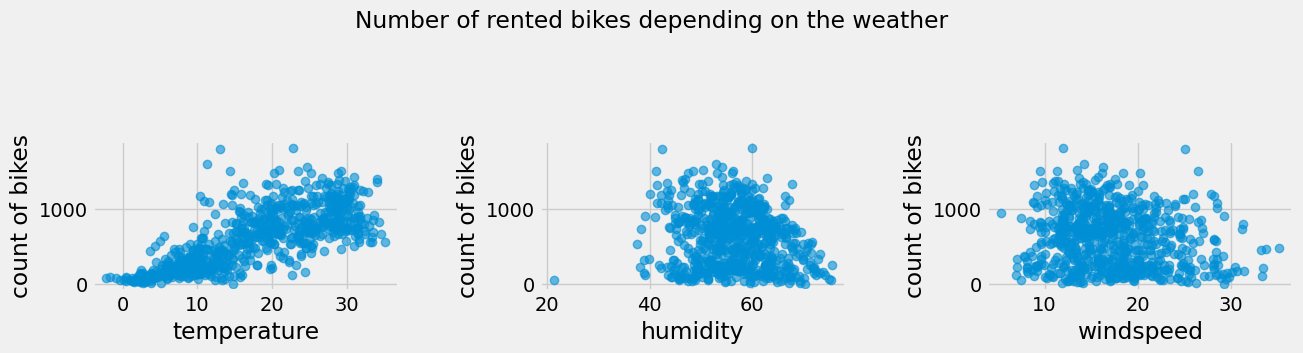

In [ ]:
plt.figure(figsize=(14,4))

for idx in np.arange(1,4):
    x = bikes[bikes.columns[idx]]
    y = bikes[bikes.columns[4]]
    plt.subplot(1, 3, idx)
    plt.plot(x, y, 'o', alpha=0.6)
    plt.xlabel(bikes.columns[idx])
    plt.ylabel('count of bikes')

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
plt.suptitle("Number of rented bikes depending on the weather")
plt.tight_layout(pad=3.0)
plt.axis("tight")
plt.show()

**Nice - there is a relation between the temperature and the bikes!**

*   How many bikes will be hired with a temperature of $\{5, 10, 20, 30\}$ degrees?


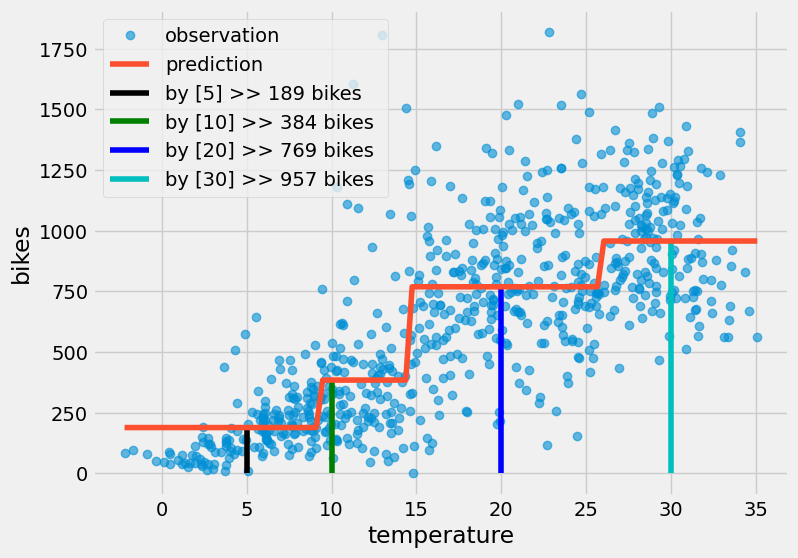

In [ ]:
idx_weather = 1
regressor = DecisionTreeRegressor(max_depth=2)
regressor.fit(np.array([bikes[bikes.columns[idx_weather]]]).T, bikes['count'])

xx = np.array([np.linspace(min(bikes[bikes.columns[idx_weather]]),
                           max(bikes[bikes.columns[idx_weather]]), 100)]).T

plt.figure(figsize=(8,6))
plt.plot(bikes[bikes.columns[idx_weather]], bikes['count'], 'o',
         alpha=.6, label='observation')
plt.plot(xx, regressor.predict(xx), linewidth=4, label='prediction', zorder=4)

x_test = np.array([5, 10, 20, 30]).reshape(-1,1)
y_predict = regressor.predict(x_test).astype(int)
colors = 'kgbc'
for idx in np.arange(x_test.shape[0]):
  label = f'by {x_test[idx]} >> {y_predict[idx]} bikes '
  plt.vlines(x=x_test[idx], ymin=0, ymax = y_predict[idx], linewidth=4,
             color=colors[idx], label=label, zorder=3)

plt.xlabel(bikes.columns[idx_weather])
plt.ylabel('bikes')
plt.legend()
plt.show()

**Decision Tree - overfitting**

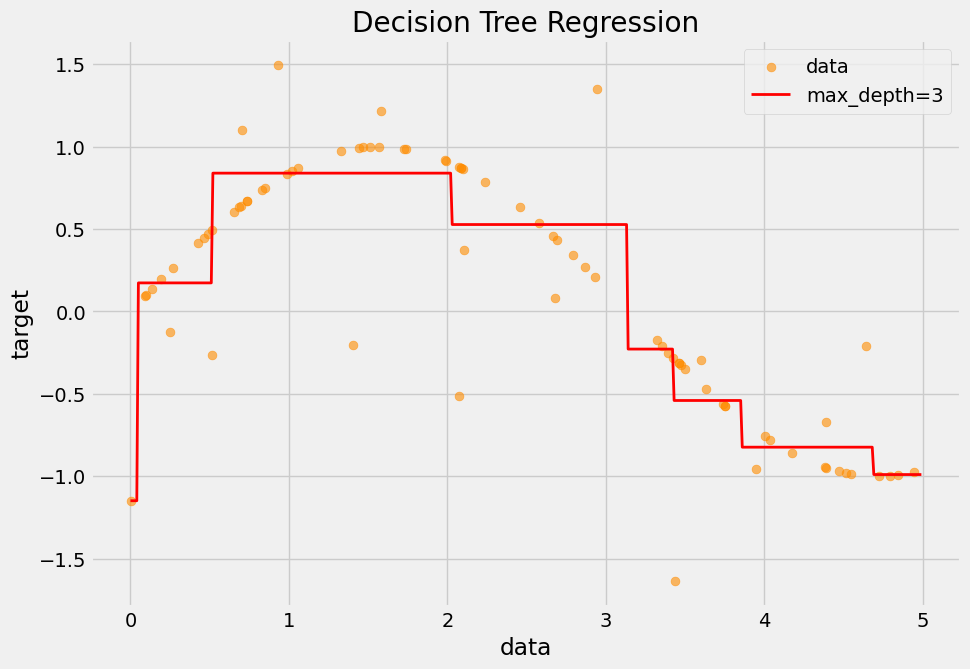

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset - try it also without the noise
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))
plt.figure(figsize=[10,7])
plt.scatter(X, y, s=40, c="darkorange", alpha=0.6, label="data")

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
colors = 'rgbc'
depth = [3]
# depth = [2,3,4,5]
for idx in np.arange(len(depth)):
  # Fit regression model
  regr = DecisionTreeRegressor(max_depth=depth[idx])
  regr.fit(X, y)
  # Predict
  y_predict = regr.predict(X_test)
  # Plot the results
  plt.plot(X_test, y_predict, color=colors[idx],
           label=f"max_depth={depth[idx]}",
           linewidth=2, zorder=(len(depth)+1-idx))
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

# Part 3: Random Forest

## Theory
*   Based on Decision Trees

<img src="https://staff.utia.cas.cz/novozada/ml1/randomforest.png">

### Advantages of Decision Trees:
*   More accurate than the decision tree algorithm.
*   Very stable - Even if a new data point is introduced >> new data may impact one tree, but it is very hard for it to impact all the trees.
*   It can produce a reasonable prediction without hyper-parameter tuning.
*   It provides an effective way of handling missing data.
*   Works well when you have both categorical and numerical features.
*   It solves the issue of overfitting in decision trees.

### Disadvantages of Decision Trees:
*   A major disadvantage of random forests lies in their complexity - the large number of decision trees joined together.

## Code

In [ ]:
# Import the necessary modules and libraries
import numpy as np
from collections import Counter

def bootstrap_sample(X, y):
  n_samples = X.shape[0]
  idxs = np.random.choice(n_samples, size=n_samples, replace=True)
  return X[idxs], y[idxs]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

class RandomForest:

  def __init__(self, n_trees=100, min_samples_split=2, max_depth=100, n_feats=None):
    self.n_trees = n_trees
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.n_feats = n_feats
    self.trees = []

  def fit(self, X, y):
    self.trees = []
    for _ in range(self.n_trees):
      tree = DecisionTree(min_samples_split=self.min_samples_split,
                          max_depth=self.max_depth, n_feats=self.n_feats)
      X_sample, y_sample = bootstrap_sample(X, y)
      tree.fit(X_sample, y_sample)
      self.trees.append(tree)

  def predict(self, X):
    tree_preds = np.array([tree.predict(X) for tree in self.trees])
    # [[1111], [0000], [1111]] ==>> [[101], [101], [101], [101]]
    tree_preds = np.swapaxes(tree_preds, 0, 1)
    y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
    return np.array(y_pred)

### Random Forests Classification

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

clf = RandomForest(n_trees=3, max_depth=10)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy:", acc)


Accuracy: 0.9473684210526315


### Random Forests Regression

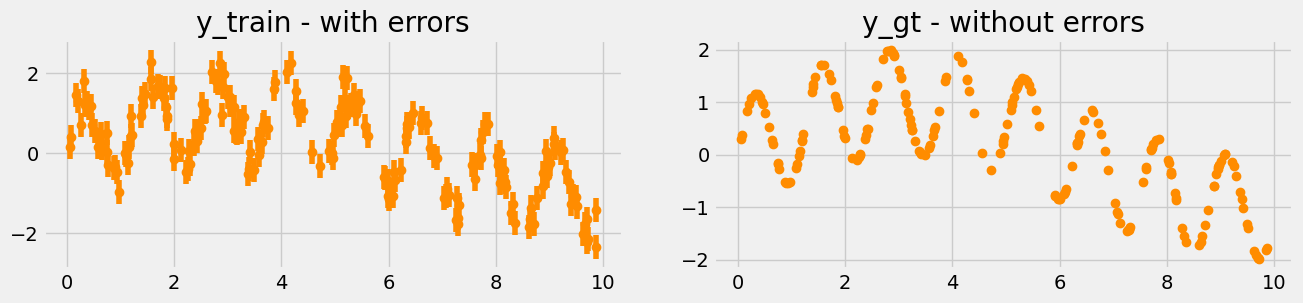

In [ ]:
rng = np.random.RandomState(42)
X = 10 * rng.rand(200)
sigma = 0.3

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y_train = model(X)
y_gt = model(X, sigma = 0)

plt.figure(figsize=(14,4))
plt.subplot(1, 2, 1)
plt.title('y_train - with errors')
plt.errorbar(X, y_train, 0.3, fmt='o', c="darkorange");
plt.subplot(1, 2, 2)
plt.title('y_gt - without errors')
plt.errorbar(X, y_gt, 0.0, fmt='o', c="darkorange");
plt.tight_layout(pad=3.0)

Using the random forest regressor, we can find the best fit curve as follows:

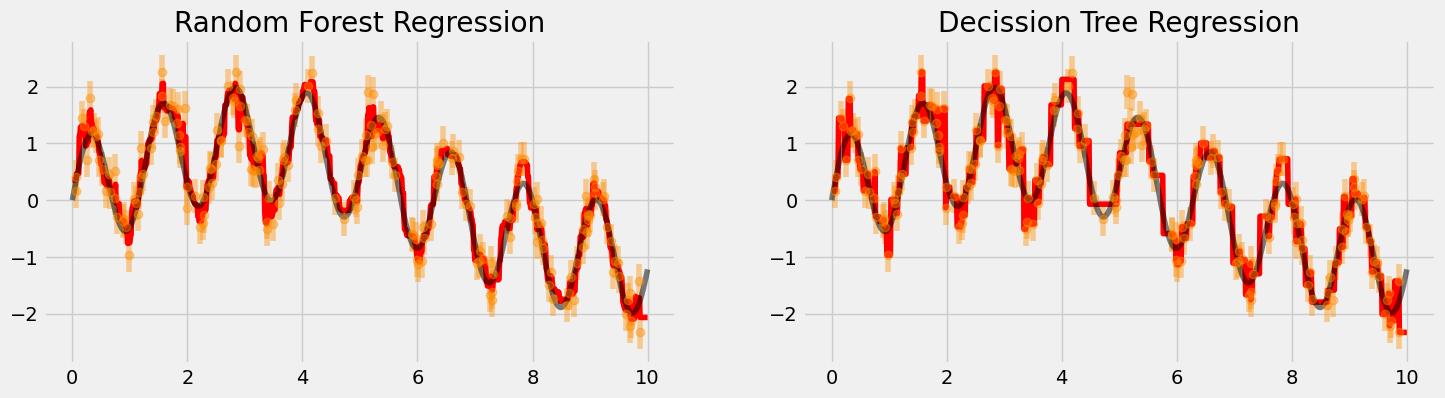

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

regr_forest = RandomForestRegressor(200)
regr_tree = DecisionTreeRegressor(max_depth=10)
regr_forest.fit(X[:, None], y_train)
regr_tree.fit(X[:, None], y_train)


Xfit = np.linspace(0, 10, 1000)
y_fit = model(Xfit, sigma = 0)
y_forest = regr_forest.predict(Xfit[:, None])
y_tree = regr_tree.predict(Xfit[:, None])

plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
plt.title('Random Forest Regression')
plt.errorbar(X, y_train, sigma, fmt='o', c="darkorange", alpha=0.4);
plt.plot(Xfit, y_forest, '-r');
plt.plot(Xfit, y_fit, '-k', alpha=0.5);

plt.subplot(1, 2, 2)
plt.title('Decission Tree Regression')
plt.errorbar(X, y_train, sigma, fmt='o', c="darkorange", alpha=0.4);
plt.plot(Xfit, y_tree, '-r');
plt.plot(Xfit, y_fit, '-k', alpha=0.5);

